In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import keras.backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *

In [2]:
# Import tweets and sentiment data

dataset = pd.read_excel('sample_tweets.xlsx')[['SentimentText','Sentiment']]
dataset = dataset[dataset['Sentiment'] != 'Neutral']

tweets = dataset['SentimentText'].values
sent = dataset['Sentiment'].values

In [3]:
print(tweets[0], sent[0])

#gstnfailed @nsitharaman .. Such a bold step.. Made by extending 3 days.. Now v know.. V should never vote & give majority to @BJP4India @PMOIndia .. Such a foolish step.. Really saddened to know.. Dat u don't understand d stress. of GST professionals.. Negative


In [4]:
# Create embedding_vector for each word using Word2Vec

word2vec = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
emb_dim = 300
print(word2vec['car'])

[ 0.13085938  0.00842285  0.03344727 -0.05883789  0.04003906 -0.14257812
  0.04931641 -0.16894531  0.20898438  0.11962891  0.18066406 -0.25
 -0.10400391 -0.10742188 -0.01879883  0.05200195 -0.00216675  0.06445312
  0.14453125 -0.04541016  0.16113281 -0.01611328 -0.03088379  0.08447266
  0.16210938  0.04467773 -0.15527344  0.25390625  0.33984375  0.00756836
 -0.25585938 -0.01733398 -0.03295898  0.16308594 -0.12597656 -0.09912109
  0.16503906  0.06884766 -0.18945312  0.02832031 -0.0534668  -0.03063965
  0.11083984  0.24121094 -0.234375    0.12353516 -0.00294495  0.1484375
  0.33203125  0.05249023 -0.20019531  0.37695312  0.12255859  0.11425781
 -0.17675781  0.10009766  0.0030365   0.26757812  0.20117188  0.03710938
  0.11083984 -0.09814453 -0.3125      0.03515625  0.02832031  0.26171875
 -0.08642578 -0.02258301 -0.05834961 -0.00787354  0.11767578 -0.04296875
 -0.17285156  0.04394531 -0.23046875  0.1640625  -0.11474609 -0.06030273
  0.01196289 -0.24707031  0.32617188 -0.04492188 -0.114257

In [6]:
# create weight matrix for embedding layer and convert tweets data

word_to_idx = dict()
ind = 0
wt_mat = []
X = []
re = RegexpTokenizer('[a-z]+')
sw = stopwords.words('english')

wt_mat.append(np.zeros(300))
for i in range(tweets.shape[0]):
    word = re.tokenize(tweets[i].lower())
    
    vec = np.zeros(50)
    for j in range(min(len(word), 50)):
        w = word[j]
        if w in sw or len(w) < 3 or w not in word2vec:
            continue
        if w not in word_to_idx:
            ind += 1
            word_to_idx[w] = ind
            wt_mat.append(word2vec[w])
        
        vec[j] = word_to_idx[w]
        j += 1
    X.append(vec)

X = np.array(X)
wt_mat = np.array(wt_mat)

In [7]:
print(wt_mat.shape)

(3999, 300)


In [8]:
# prepare training and test data

le = LabelEncoder()
y = le.fit_transform(sent)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape, y_test.shape)

(5686, 50) (1422,)


In [9]:
print(X_train[0], y_train[0])

[  0.   0.  12.   0. 492.   0.   0. 305.   0.   0.  69.   0.  12.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.] 0


In [10]:
# Custom Attention Layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x*at
        return K.sum(output, axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(attention, self).get_config()

In [11]:
# Create model with LSTM and Attention Layer

model = Sequential()
model.add(Embedding(wt_mat.shape[0], emb_dim, mask_zero=True, weights=[wt_mat], input_length=50, trainable=False))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.25))
model.add(attention())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           1199700   
_________________________________________________________________
lstm (LSTM)                  (None, 50, 32)            42624     
_________________________________________________________________
dropout (Dropout)            (None, 50, 32)            0         
_________________________________________________________________
attention (attention)        (None, 32)                82        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,242,439
Trainable params: 42,739
Non-trainable params: 1,199,700
_________________________________________

In [12]:
# Train model

hist = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
143/143 [==============================] - 5s 37ms/step - loss: 0.2589 - acc: 0.9237 - val_loss: 0.1787 - val_acc: 0.9359
Epoch 2/10
143/143 [==============================] - 4s 29ms/step - loss: 0.1450 - acc: 0.9569 - val_loss: 0.1521 - val_acc: 0.9569
Epoch 3/10
143/143 [==============================] - 5s 35ms/step - loss: 0.1164 - acc: 0.9668 - val_loss: 0.1179 - val_acc: 0.9596
Epoch 4/10
143/143 [==============================] - 5s 33ms/step - loss: 0.1005 - acc: 0.9670 - val_loss: 0.1201 - val_acc: 0.9613
Epoch 5/10
143/143 [==============================] - 5s 33ms/step - loss: 0.0840 - acc: 0.9743 - val_loss: 0.1080 - val_acc: 0.9675
Epoch 6/10
143/143 [==============================] - 10s 70ms/step - loss: 0.0759 - acc: 0.9767 - val_loss: 0.1073 - val_acc: 0.9622
Epoch 7/10
143/143 [==============================] - 7s 50ms/step - loss: 0.0653 - acc: 0.9798 - val_loss: 0.0956 - val_acc: 0.9736
Epoch 8/10
143/143 [==============================] - 6s 45ms/step -

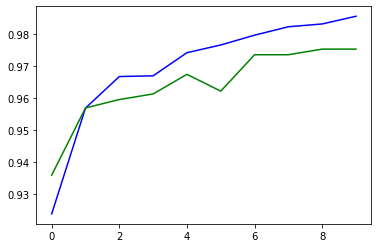

In [13]:
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='g')
plt.show()

In [14]:
# Get Equal Positive and negative class data for testing

n = min(np.unique(y_test, return_counts = True)[1])
n0 = n1 = 0
idx = []

for ix in range(y_test.shape[0]):
    if y_test[ix] == 0 and n0 < n:
        idx.append(ix)
        n0 += 1
    if y_test[ix] == 1 and n1 < n:
        idx.append(ix)
        n1 += 1

idx = np.array(idx)
print(idx.shape)

X_test2 = X_test[idx]
y_test2 = y_test[idx]
print(np.unique(y_test2, return_counts = True))

(178,)
(array([0, 1]), array([89, 89], dtype=int64))


In [16]:
print(le.inverse_transform([0, 1]))

y_pred = model.predict_classes(X_test2)
print(confusion_matrix(y_pred, y_test2))

['Negative' 'Positive']
[[88 27]
 [ 1 62]]
